In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
%matplotlib inline
import matplotlib.pyplot as plt

from auraliser import Auraliser, mono
from auraliser.generator import Sine, Noise, NoiseBands
from acoustics.directivity import Omni
from acoustics.signal import OctaveBand
from acoustics.reflection import Boundary
from geometry import Point
from ism import Model, Wall, plot_walls
from IPython.display import Audio
import warnings
#warnings.filterwarnings('ignore')

#import mpld3
#from mpld3 import enable_notebook
#enable_notebook()
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
fs = 11025.      # Sample frequency
duration = 10.      # Duration in seconds
df = 50.0           # Frequency resolution (impedances reflections)

dt = 1.0/fs                             # Seconds per sample
t = np.arange(0.0, duration, dt)        # Time vector

In [3]:
velocity = 60.0                         # Velocity of source in meters per second.
distance = velocity * duration          # Total distance covered

x = np.ones_like(t) * velocity * (t - duration/2.0)    # Source moves along the x-axis.
y = np.ones_like(t) * 1.0
z = np.ones_like(t) * 100.0   # Altitude of source

In [4]:
model = Auraliser(duration=duration, sample_frequency=fs)

In [5]:
src = model.add_source(name='src', position=np.vstack((x,y,z)).T)
sub = src.add_subsource(name='sub')
noise = sub.add_virtualsource('noise')
noise.signal = Noise()
noise.directivity = Omni()
tone = sub.add_virtualsource('tone')
tone.signal = Sine(1000.0)
tone.directivity = Omni()

In [6]:
rcv = model.add_receiver(name='receiver', position=Point(0.0,0.0,1.6))

In [7]:
flow_resistivity = 2.0e5 # Grass
frequencies = np.arange(0.0, fs/2.0, df)
boundary = Boundary(frequencies, flow_resistivity)
impedance = np.nan_to_num(boundary.impedance)

In [8]:
model.settings['reflections']['mirrors_threshold'] = None

# Ground reflection

The first case to consider is when the model consists only of a single surface and the surface reflects.

In [9]:
groundcorners1 = [Point(-100.0, -100.0, 0.0), 
                  Point(100.0, -100.0, 0.0), 
                  Point(100.0, 100.0, 0.0), 
                  Point(-100.0, 100.0, 0.0) ]
ground1 = Wall(groundcorners1, impedance, Point(0.0, 0.0, 0.0))
#ground2 = Wall(groundcorners1[::-1], impedance, Point(0.0, 0.0, 0.0))

In [10]:
walls = [ground1]
model.geometry.walls = walls

INFO:root:Start calculating image sources.
INFO:root:Main source effective: True
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Storing mirror.
INFO:root:Order: 2 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Illegal- Generating wall of this mirror.


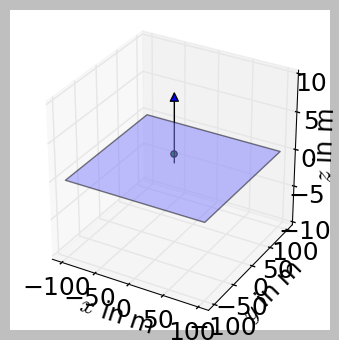

In [11]:
ism = Model(walls, source=[Point(*src.position[0])], receiver=[Point(*rcv.position[0])]) 
fig = ism.plot()

In [12]:
for mirror in ism.determine():
    print(mirror, mirror.effective)

INFO:root:Start calculating image sources.
INFO:root:Main source effective: True
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Storing mirror.
INFO:root:Order: 2 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Illegal- Generating wall of this mirror.


(0,(-300.0, 1.0, 100.0)) [1]
(1,(-300.0, 1.0, -100.0)) [1]


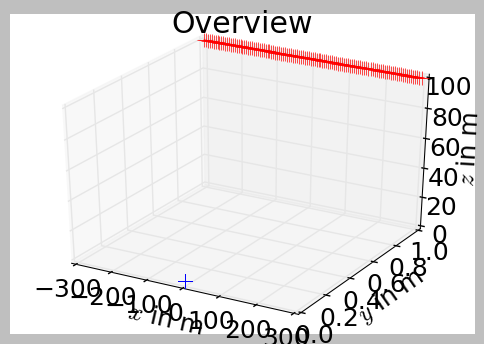

In [13]:
fig = model.plot()

In [14]:
model.settings['turbulence']['include'] = False

In [15]:
contributions = list( rcv.auralise() )

INFO:root:Auralising at receiver
INFO:root:Can auralise.
INFO:root:Auralising source src
INFO:root:Determining mirrors sources.
INFO:root:Start calculating image sources.
INFO:root:Main source effective: False
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Storing mirror.
INFO:root:Order: 2 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Illegal- Generating wall of this mirror.
INFO:root:Applying source effects...
INFO:root:Auralising mirror
INFO:root:Applying Doppler frequency shift.
INFO:root:Applying atmospheric absorption.
INFO:root:Applying spherical spreading.
INFO:root:Applying source effects...
INFO:root:Auralising mirror
INFO:root:Applying Doppler frequency shift.
INFO:root:Applying atmospheric absorption.
INFO:root:Applying spherical spreading.
INFO:root:Finished auralising source src


[-0.00149428  0.00094287  0.00623909 ..., -0.35755071 -0.2572127
 -0.14591095]


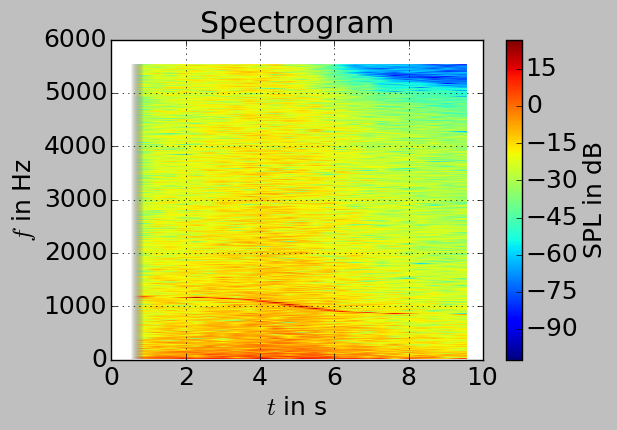

In [16]:
fig = contributions[0][0].spectrogram()

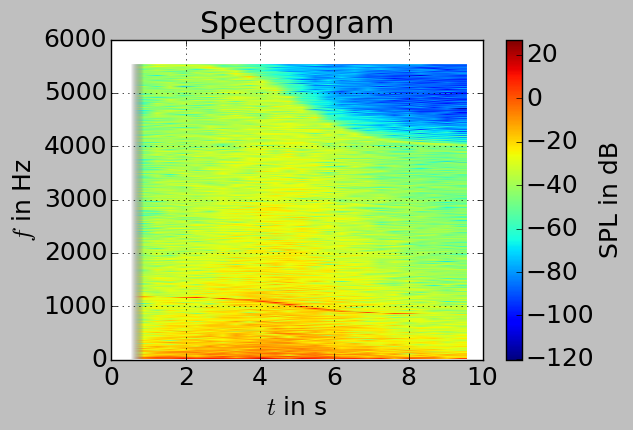

In [17]:
fig = contributions[1][0].spectrogram()

In [18]:
signal = mono(contributions)
Audio(data=signal, rate=signal.fs)

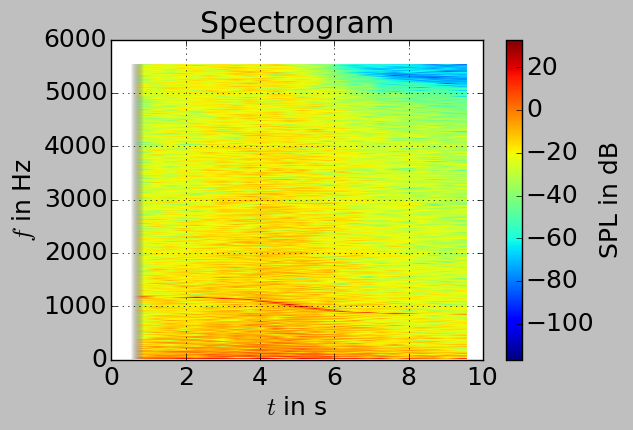

In [19]:
fig = signal.spectrogram()

In [20]:
list(ism.mirrors())

INFO:root:Start calculating image sources.
INFO:root:Main source effective: True
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Storing mirror.
INFO:root:Order: 2 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Illegal- Generating wall of this mirror.


[Mirror((0,(-300.0, 1.0, 100.0))), Mirror((1,(-300.0, 1.0, -100.0)))]

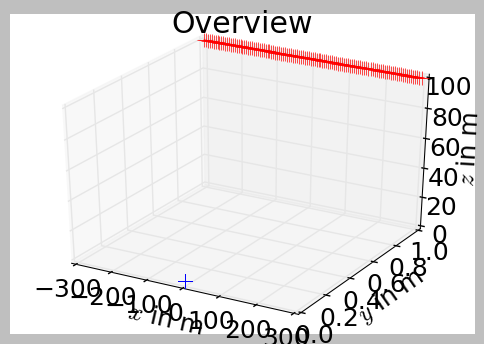

In [21]:
fig = model.plot(interval=1000)

In [22]:
print(rcv.position)

[[ 0.   0.   1.6]
 [ 0.   0.   1.6]
 [ 0.   0.   1.6]
 ..., 
 [ 0.   0.   1.6]
 [ 0.   0.   1.6]
 [ 0.   0.   1.6]]


# Shielding wall

In this case a single wall blocks sound from source to receiver.

In [23]:
shield1 = Wall([Point(-20.0, +100.0, 0.0),
           Point(-20.0, +100.0, +10.0),
           Point(-20.0, -100.0, +10.0),
           Point(-20.0, -100.0, 0.0)][::+1], impedance, Point(-20.0, 0.0, +5.0))

#shield2 = Wall(shield1.points[::-1], impedance, shield1.center)

walls = [shield1]#, shield2]

INFO:root:Start calculating image sources.
INFO:root:Main source effective: True
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-20.0, 100.0, 0.0), Point(-20.0, 100.0, 10.0), Point(-20.0, -100.0, 10.0), Point(-20.0, -100.0, 0.0)] - Illegal - Mirror on wrong side of wall. Position: (-300.0, 1.0, 100.0)


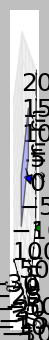

In [24]:
ism = Model(walls, source=[Point(*src.position[0])], receiver=[Point(*rcv.position[0])], max_order=3)
fig = ism.plot()

In [25]:
for mirror in ism.determine():
    print( mirror, mirror.effective )
model.geometry.walls = walls

INFO:root:Start calculating image sources.
INFO:root:Main source effective: True
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-20.0, 100.0, 0.0), Point(-20.0, 100.0, 10.0), Point(-20.0, -100.0, 10.0), Point(-20.0, -100.0, 0.0)] - Illegal - Mirror on wrong side of wall. Position: (-300.0, 1.0, 100.0)


(0,(-300.0, 1.0, 100.0)) [1]


In [26]:
signal = mono(rcv.auralise())

INFO:root:Auralising at receiver
INFO:root:Can auralise.
INFO:root:Auralising source src
INFO:root:Determining mirrors sources.
INFO:root:Start calculating image sources.
INFO:root:Main source effective: True
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-20.0, 100.0, 0.0), Point(-20.0, 100.0, 10.0), Point(-20.0, -100.0, 10.0), Point(-20.0, -100.0, 0.0)] - Storing mirror.
INFO:root:Order: 2 - Mirror: 1 - Wall: [Point(-20.0, 100.0, 0.0), Point(-20.0, 100.0, 10.0), Point(-20.0, -100.0, 10.0), Point(-20.0, -100.0, 0.0)] - Illegal- Generating wall of this mirror.
INFO:root:Applying source effects...
INFO:root:Auralising mirror
INFO:root:Applying Doppler frequency shift.
INFO:root:Applying atmospheric absorption.
INFO:root:Applying spherical spreading.
INFO:root:Applying source effects...
INFO:root:Auralising mirror
INFO:root:Applying Doppler frequency shift.
INFO:root:Applying atmospheric absorption.
INFO:root:Applying spherical spreading.
INFO:root:Finished auralising source src


[ 0.          0.          0.         ..., -0.18478221  0.12381572
  0.18167701]


In [27]:
Audio(data=signal, rate=signal.fs)

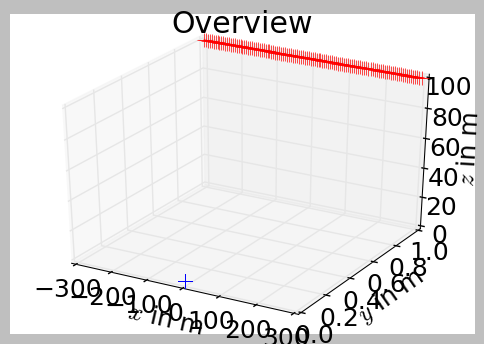

In [28]:
fig = model.plot()

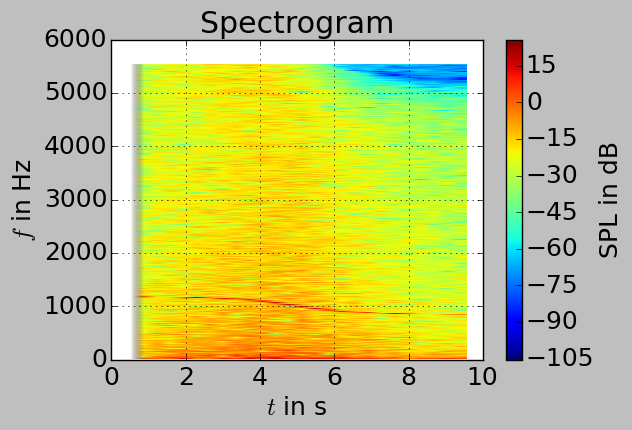

In [29]:
fig = signal.spectrogram()

# Ground reflection and wall shielding

In [30]:
walls = [ground1, shield1]
ism = Model(walls, source=[Point(*src.position[0])], receiver=[Point(*rcv.position[0])]) 
#ism =  Model(walls, source=[Point(*sample) for sample in src.position], receiver=[Point(*sample) for sample in rcv.position])
#ism =  Model(walls, source=[Point(*sample) for sample in src.position], receiver=[Point(*sample) for sample in rcv.position])
#fig = ism.plot()

In [31]:
#for mirror in ism.determine():
#    print(mirror, mirror.effective)

In [32]:
model.geometry.walls = walls

In [33]:
signal = mono(rcv.auralise())

INFO:root:Auralising at receiver
INFO:root:Can auralise.
INFO:root:Auralising source src
INFO:root:Determining mirrors sources.
INFO:root:Start calculating image sources.
INFO:root:Main source effective: False
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Storing mirror.
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-20.0, 100.0, 0.0), Point(-20.0, 100.0, 10.0), Point(-20.0, -100.0, 10.0), Point(-20.0, -100.0, 0.0)] - Storing mirror.
INFO:root:Order: 2 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Illegal- Generating wall of this mirror.
INFO:root:Order: 2 - Mirror: 1 - Wall: [Point(-20.0, 100.0, 0.0), Point(-20.0, 100.0, 10.0), Point(-20.0, -100.0, 10.0), Point(-20.0, -100.0, 0.0)] - Illegal - Center of wall cannot be seen.
INFO:root:Order: 2 - Mirror: 2 - Wall: [Point(-100.0, -100.0, 0.0), Point(10

[-0.00048262 -0.00553368  0.00923483 ..., -0.37967642 -0.29660247
 -0.28425695]
[ 0.          0.          0.         ..., -0.19656218 -0.2221825
 -0.14197593]

INFO:root:Auralising mirror
INFO:root:Applying Doppler frequency shift.
INFO:root:Applying atmospheric absorption.
INFO:root:Applying spherical spreading.
INFO:root:Finished auralising source src


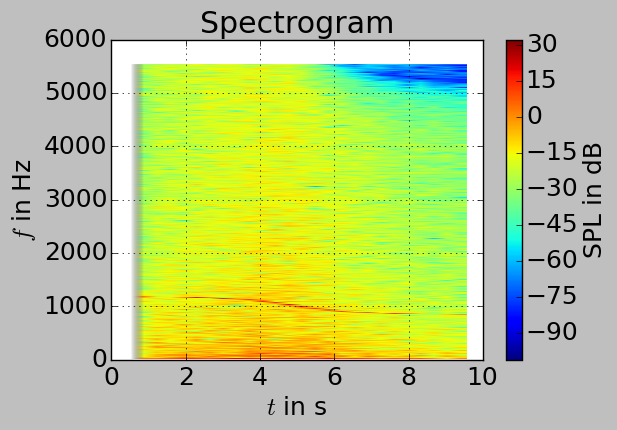

In [34]:
fig = signal.spectrogram()

# Ground and wall reflection

In this case a second surface is added which also reflects.

In [35]:
wall1 = Wall([Point(-100.0, +10.0, 0.0),
           Point(-100.0, +10.0, +10.0),
           Point(+100.0, +10.0, +10.0),
           Point(+100.0, +10.0, 0.0)][::-1], impedance, Point(0.0, +10.0, +5.0))

In [36]:
walls = [ground1, wall1]

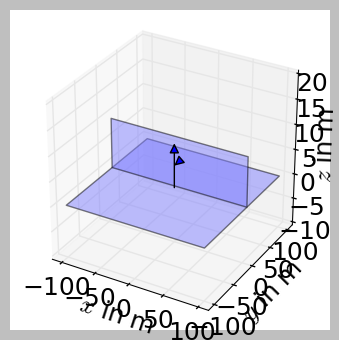

In [37]:
fig = plot_walls(walls)

In [38]:
model.geometry.walls = walls

INFO:root:Start calculating image sources.
INFO:root:Main source effective: True
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Storing mirror.
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(100.0, 10.0, 0.0), Point(100.0, 10.0, 10.0), Point(-100.0, 10.0, 10.0), Point(-100.0, 10.0, 0.0)] - Storing mirror.
INFO:root:Order: 2 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Illegal- Generating wall of this mirror.
INFO:root:Order: 2 - Mirror: 1 - Wall: [Point(100.0, 10.0, 0.0), Point(100.0, 10.0, 10.0), Point(-100.0, 10.0, 10.0), Point(-100.0, 10.0, 0.0)] - Illegal - Center of wall cannot be seen.
INFO:root:Order: 2 - Mirror: 2 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Illegal - Center of wall cannot be seen.
INFO:root:Order: 2 - M

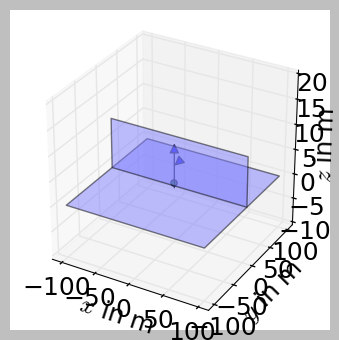

In [39]:
ism = Model(walls, source=[Point(*src.position[0])], receiver=[Point(*rcv.position[0])]) 
fig = ism.plot()

In [40]:
for mirror in ism.determine():
    print(mirror, mirror.effective)

INFO:root:Start calculating image sources.
INFO:root:Main source effective: True
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Storing mirror.
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(100.0, 10.0, 0.0), Point(100.0, 10.0, 10.0), Point(-100.0, 10.0, 10.0), Point(-100.0, 10.0, 0.0)] - Storing mirror.
INFO:root:Order: 2 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Illegal- Generating wall of this mirror.
INFO:root:Order: 2 - Mirror: 1 - Wall: [Point(100.0, 10.0, 0.0), Point(100.0, 10.0, 10.0), Point(-100.0, 10.0, 10.0), Point(-100.0, 10.0, 0.0)] - Illegal - Center of wall cannot be seen.
INFO:root:Order: 2 - Mirror: 2 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Illegal - Center of wall cannot be seen.
INFO:root:Order: 2 - M

(0,(-300.0, 1.0, 100.0)) [1]
(1,(-300.0, 1.0, -100.0)) [1]
(1,(-300.0, 19.0, 100.0)) [0]


In [41]:
signal = mono(rcv.auralise())

INFO:root:Auralising at receiver
INFO:root:Can auralise.
INFO:root:Auralising source src
INFO:root:Determining mirrors sources.
INFO:root:Start calculating image sources.
INFO:root:Main source effective: False
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Storing mirror.
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(100.0, 10.0, 0.0), Point(100.0, 10.0, 10.0), Point(-100.0, 10.0, 10.0), Point(-100.0, 10.0, 0.0)] - Storing mirror.
INFO:root:Order: 2 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Illegal- Generating wall of this mirror.
INFO:root:Order: 2 - Mirror: 1 - Wall: [Point(100.0, 10.0, 0.0), Point(100.0, 10.0, 10.0), Point(-100.0, 10.0, 10.0), Point(-100.0, 10.0, 0.0)] - Illegal - Center of wall cannot be seen.
INFO:root:Order: 2 - Mirror: 2 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -10

[-0.00374362  0.00496958  0.00614009 ...,  0.10299017  0.1894934
  0.33193391]
[ 0.  0.  0. ...,  0.  0.  0.]

INFO:root:Auralising mirror
INFO:root:Applying Doppler frequency shift.
INFO:root:Applying atmospheric absorption.
INFO:root:Applying spherical spreading.
INFO:root:Finished auralising source src


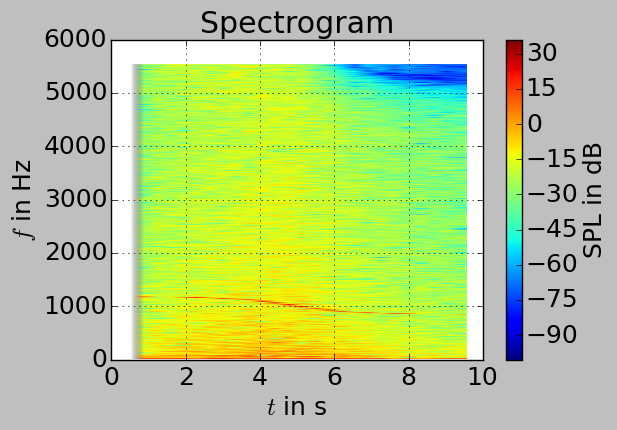

In [42]:
fig = signal.spectrogram()

# Shielding

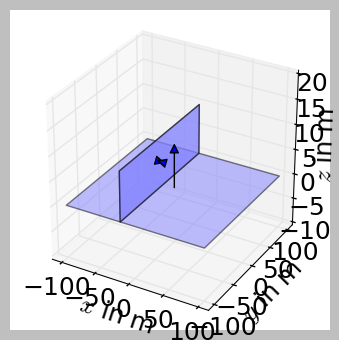

In [43]:
shield1 = Wall([Point(-20.0, +100.0, 0.0),
           Point(-20.0, +100.0, +10.0),
           Point(-20.0, -100.0, +10.0),
           Point(-20.0, -100.0, 0.0)][::+1], impedance, Point(-20.0, 0.0, +5.0))
shield2 = Wall(shield1.points[::-1], impedance, shield1.center)
walls = [ground1, shield1, shield2]

fig = plot_walls(walls)


INFO:root:Start calculating image sources.
INFO:root:Main source effective: True
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Storing mirror.
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-20.0, 100.0, 0.0), Point(-20.0, 100.0, 10.0), Point(-20.0, -100.0, 10.0), Point(-20.0, -100.0, 0.0)] - Illegal - Mirror on wrong side of wall. Position: (-300.0, 1.0, 100.0)
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-20.0, -100.0, 0.0), Point(-20.0, -100.0, 10.0), Point(-20.0, 100.0, 10.0), Point(-20.0, 100.0, 0.0)] - Storing mirror.
INFO:root:Order: 2 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Illegal- Generating wall of this mirror.
INFO:root:Order: 2 - Mirror: 1 - Wall: [Point(-20.0, 100.0, 0.0), Point(-20.0, 100.0, 10.0), Point(-20.0, -100.0, 10.0), Point(-20.0, -100.0, 0.0)] - Illegal - Mirror on wrong

[Mirror((0,(-300.0, 1.0, 100.0))),
 Mirror((1,(-300.0, 1.0, -100.0))),
 Mirror((1,(260.0, 1.0, 100.0))),
 Mirror((2,(260.0, 1.0, -100.0))),
 Mirror((2,(-300.0, 1.0, 100.0))),
 Mirror((3,(-300.0, 1.0, -100.0))),
 Mirror((3,(-300.0, 1.0, -100.0))),
 Mirror((3,(260.0, 1.0, 100.0)))]

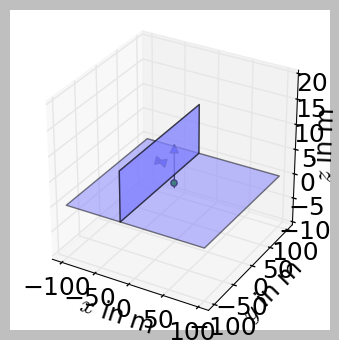

In [44]:
ism = Model(walls, source=[Point(*src.position[0])], receiver=[Point(*rcv.position[0])], max_order=3) 
ism.determine()
fig = ism.plot()
list(ism.mirrors())

In [45]:
for mirror in ism.determine():
    print(mirror.effective)
    print( mirror, mirror.effective.any())

INFO:root:Start calculating image sources.
INFO:root:Main source effective: True
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Storing mirror.
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-20.0, 100.0, 0.0), Point(-20.0, 100.0, 10.0), Point(-20.0, -100.0, 10.0), Point(-20.0, -100.0, 0.0)] - Illegal - Mirror on wrong side of wall. Position: (-300.0, 1.0, 100.0)
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-20.0, -100.0, 0.0), Point(-20.0, -100.0, 10.0), Point(-20.0, 100.0, 10.0), Point(-20.0, 100.0, 0.0)] - Storing mirror.
INFO:root:Order: 2 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Illegal- Generating wall of this mirror.
INFO:root:Order: 2 - Mirror: 1 - Wall: [Point(-20.0, 100.0, 0.0), Point(-20.0, 100.0, 10.0), Point(-20.0, -100.0, 10.0), Point(-20.0, -100.0, 0.0)] - Illegal - Mirror on wrong

[1]
(0,(-300.0, 1.0, 100.0)) True
[1]
(1,(-300.0, 1.0, -100.0)) True
[0]
(1,(260.0, 1.0, 100.0)) False
[0]
(2,(260.0, 1.0, -100.0)) False
[1]
(2,(-300.0, 1.0, 100.0)) True
[0]
(3,(-300.0, 1.0, -100.0)) False
[1]
(3,(-300.0, 1.0, -100.0)) True
[0]
(3,(260.0, 1.0, 100.0)) False


In [46]:
model.geometry.walls = walls

In [47]:
model.settings['reflections']['order_threshold'] = 1
signal = mono(rcv.auralise())
Audio(data=signal, rate=signal.fs)

INFO:root:Auralising at receiver
INFO:root:Can auralise.
INFO:root:Auralising source src
INFO:root:Determining mirrors sources.
INFO:root:Start calculating image sources.
INFO:root:Main source effective: False
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-100.0, -100.0, 0.0), Point(100.0, -100.0, 0.0), Point(100.0, 100.0, 0.0), Point(-100.0, 100.0, 0.0)] - Storing mirror.
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-20.0, 100.0, 0.0), Point(-20.0, 100.0, 10.0), Point(-20.0, -100.0, 10.0), Point(-20.0, -100.0, 0.0)] - Storing mirror.
INFO:root:Order: 1 - Mirror: 1 - Wall: [Point(-20.0, -100.0, 0.0), Point(-20.0, -100.0, 10.0), Point(-20.0, 100.0, 10.0), Point(-20.0, 100.0, 0.0)] - Illegal - Mirror on wrong side of wall. Position: (0.0, 0.0, 1.6)
INFO:root:Applying source effects...
INFO:root:Auralising mirror
INFO:root:Applying Doppler frequency shift.
INFO:root:Applying atmospheric absorption.
INFO:root:Applying spherical spreading.
INFO:root:Applying source effects...
INFO:root:Aur

[ -5.44928504e-05  -2.49820749e-03   2.65071596e-03 ...,  -1.10873385e-01
   5.13713174e-02   2.17847796e-01]
[ 0.          0.          0.         ...,  0.19487668  0.4158948
  0.46346007]

INFO:root:Auralising mirror
INFO:root:Applying Doppler frequency shift.
INFO:root:Applying atmospheric absorption.
INFO:root:Applying spherical spreading.
INFO:root:Finished auralising source src


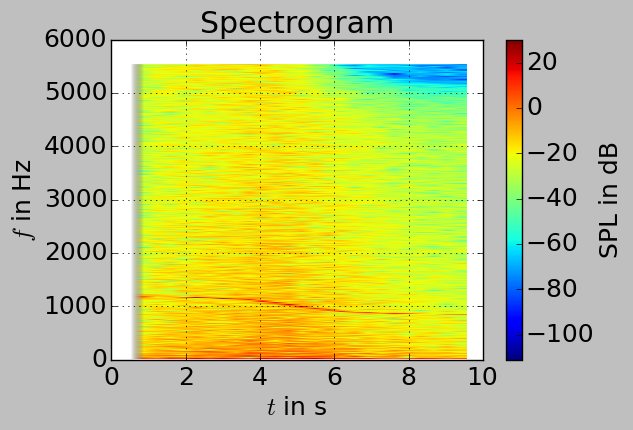

In [48]:
fig = signal.spectrogram()

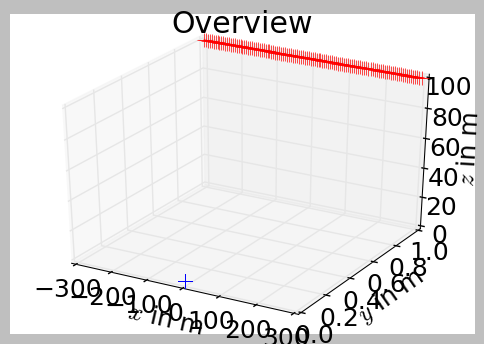

In [49]:
fig = model.plot(interval=1000)